In [32]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('science')
plt.rcParams['text.usetex'] = True
#import seaborn; seaborn.set()
import astropy.io.fits as fits
from astropy.io import ascii
from astropy.table import Table
import scipy.stats as stats
import os
import re
from pandas import DataFrame
import pandas as pd
import sys
# 定义颜色
colors = {
    'red': '#E24A33',
    'blue': '#348ABD',
    'green': '#8EBA42',
    'orange': '#FBC15E',
    'purple': '#988ED5',
    'pink': '#FFB5B8',
    'gray': '#777777'
}


def readfile(tfile): 
    with open(tfile,'r') as f:
        lines=f.readlines()
    return lines

In [33]:
source="/Volumes/WD_BLACK/Data/1A0535p262/HXMT/HHT/20201208_QPOphase/fit_results_fdcut"
path0="/Volumes/WD_BLACK/Data/1A0535p262/HXMT/HHT/20201208_QPOphase/fit_results_fdcut"
files=os.listdir("%s"%source)

In [34]:
# Models=['gabs','gaussian','fdcut']
# N_Units=[[1,1],[0],[0,0,0,0]]
# errs=[3,5,8,9,10,11,12]
# Long_index=[1,1,1]

Models=['gabs','gabs','gaussian','fdcut']
N_Units=[[1,1],[1,1,1],[0],[0,0,0,0]]
errs=[3,5,6,7,8,11,12,13,14,15]
Long_index=[2,1,1,1]

# Models=['gabs','fdcut']
# N_Units=[[1,1,1],[0,0,0,0]]
# errs=[3,4,5,9,10,11,12]
# Long_index=[1,1]

In [35]:
def read_fitresults(source,files,Models,N_Unitsi,path0):
    print(files)
    #MJD = read_MJD(files,path0)
    f = open("%s/%s"%(source,files),"r")
    all=f.read()
    #print(all)
    line_tails=readfile("%s/%s"%(source,files))
    #print(line_tails)
    j=0
    pars_values=[]
    pars_names=[]
    while j < len(Models):
        pars=re.findall(r"%s.*"%Models[j], all)
        #print(pars)
        l=len(N_Units[j])
        while l > 0:
            p=N_Units[j][-l]
            if Long_index[j] > 1:
                pars_values.append(float(pars[-l-(Long_index[j]-1)*len(N_Units[j+1])].split()[2+p]))
                #print(pars_values)
                name_str=Models[j]+'%s'%Long_index[j]+'_'+pars[-l].split()[1]
                pars_names.append(name_str)
                l-=1
            else:
                pars_values.append(float(pars[-l].split()[2+p]))
                name_str=Models[j]+'%s'%Long_index[j]+'_'+pars[-l].split()[1]
                pars_names.append(name_str)
                l-=1
        j+=1
    par_chi=re.findall(r"Test statistic : Chi-Squared.*", all)
    #print(par_chi[-1].split())
    dofall=re.findall(r"Null hypothesis probability.*", all)
    #print(dofall[-1].split())
    chi2=par_chi[-1].split()[4]
    # print(chi2)
    dof=dofall[-1].split()[6]
    # print(dof)
    red_chi2=float(chi2)/float(dof)
    # print(red_chi2)
    return pars_names, pars_values, red_chi2

In [36]:
def read_errs(source,files,errs,pars_names,pars_values):
    f = open("%s/%s"%(source,files),"r")
    all=f.read()
    #print(all)
    line_tails=readfile("%s/%s"%(source,files))
    Err=re.findall(r"Parameter   Credible Interval.*", all)
    l=0
    while l < len(line_tails):
        if Err[0] in line_tails[l]:
            L=l
        else:
            pass
        l+=1
    for e in errs:
        Errs_results=[line_tails[L+1+a].split() for a in range(len(errs))]
    pars_Err_lh=[]
    NE=0
    while NE < len(errs):
        err_low=float(Errs_results[NE][1])
        err_high=float(Errs_results[NE][2])
        pars_Err_lh.append([err_low,err_high])
        NE+=1
    #print(pars_values)
    #get err
    Np=0
    err_LR=[]
    while Np < len(pars_values):
        err_L=pars_values[Np]-pars_Err_lh[Np][0]
        err_R=pars_Err_lh[Np][1]-pars_values[Np]
        err_LR.append([err_L,err_R])
        Np+=1
    err_names_L=["%s_Lerrs"%Name for Name in pars_names]
    err_names_R=["%s_Rerrs"%Name for Name in pars_names]

    err_L=[i[0] for i in err_LR]
    err_R=[i[1] for i in err_LR]

    return err_names_L,err_L,err_names_R,err_R

In [37]:
i=0
red_chi2_all=[]
while i < len(files):
#while i < 1:
    #pars_names, pars_values,red_chi2,dof, MJD, Lum, Lum_errL, Lum_errR=read_fitresults(source,files[i],Models,N_Units,path0)
    pars_names, pars_values, red_chi2=read_fitresults(source,files[i],Models, N_Units,path0)
    red_chi2_all.append(red_chi2)
    #print(red_chi2)
    #print(pars_names)
    fit_names=pars_names
    fit_data=pars_values

    err_names_L, err_L, err_names_R, err_R=read_errs(source,files[i],errs,pars_names,pars_values)
    #print(err_names_L)
    #err_names_L, err_L = err_names_L+['Lum_errL'], err_L+[Lum_errL]
    #err_names_R, err_R = err_names_R+['Lum_errR'], err_R+[Lum_errR]
    
    derr_L=dict(zip(err_names_L,err_L))
    derr_R=dict(zip(err_names_R,err_R))
    if i==0:
        d1 = dict(zip(fit_names,fit_data))
        Para=pd.DataFrame(d1,index=['%s'%files[i]])
        Para_errL=pd.DataFrame(derr_L,index=['%s'%files[i]])
        Para_errR=pd.DataFrame(derr_R,index=['%s'%files[i]])
        i+=1
    else:
        Para.loc['%s'%files[i]]=fit_data
        Para_errL.loc['%s'%files[i]]=err_L
        Para_errR.loc['%s'%files[i]]=err_R
        i+=1
Para_all=pd.concat([Para,Para_errL,Para_errR],axis=1)
#save_data="fit_comptt_final.csv"
#Para_all.to_csv(save_data)

phase_0001.txt
phase_0102.txt
phase_0203.txt
phase_0304.txt
phase_0405.txt
phase_0506.txt
phase_0607.txt
phase_0708.txt
phase_0809.txt
phase_0910.txt


In [38]:
Para_all

,gabs2_Sigma,gabs2_Strength,gabs1_LineE,gabs1_Sigma,gabs1_Strength,gaussian1_norm,fdcut1_Gamma1,fdcut1_Ecut,fdcut1_Efold,fdcut1_norm,...,gabs2_Sigma_Rerrs,gabs2_Strength_Rerrs,gabs1_LineE_Rerrs,gabs1_Sigma_Rerrs,gabs1_Strength_Rerrs,gaussian1_norm_Rerrs,fdcut1_Gamma1_Rerrs,fdcut1_Ecut_Rerrs,fdcut1_Efold_Rerrs,fdcut1_norm_Rerrs
phase_0001.txt,114.146,12.7264,49.2479,11.31890,11.85390,0.014860,0.644587,9.08333,14.0016,1.53397,...,6.631,9.1645,0.8305,0.61630,1.26120,0.004995,0.012000,1.55017,0.1690,0.05784
phase_0102.txt,110.215,13.7151,49.3045,11.50480,9.37959,0.015228,0.637074,7.47222,14.3774,1.58570,...,2.741,6.3966,0.9564,0.72460,1.32301,0.002910,0.017556,2.13503,0.1747,0.05888
phase_0203.txt,110.883,19.1455,48.1532,10.67700,5.20958,0.016021,0.660212,7.21293,14.8750,1.65655,...,1.931,4.0146,1.0674,0.85910,1.06679,0.002830,0.011730,1.95199,0.1606,0.06861
phase_0304.txt,108.688,22.7296,47.4390,7.58006,2.21501,0.018602,0.657500,8.33075,15.2488,1.62164,...,1.988,4.6532,1.0816,1.17471,0.53562,0.002657,0.002295,0.20287,0.1541,0.04828
phase_0405.txt,109.657,26.8830,45.8961,7.35042,1.73002,0.017854,0.643765,8.85373,15.2619,1.54990,...,1.654,4.8193,1.4729,1.75708,0.30451,0.002406,0.009209,1.05784,0.2047,0.05998
phase_0506.txt,109.472,23.7007,46.1403,7.65651,1.84939,0.015277,0.632826,7.25685,15.3455,1.59526,...,2.532,7.6044,0.8511,1.69992,0.58856,0.003582,0.011217,1.26042,0.1240,0.03501
phase_0607.txt,112.703,29.0086,47.3092,8.71340,3.19477,0.018509,0.631387,5.42132,15.3205,1.68758,...,2.538,5.3428,0.3772,0.85649,0.54849,0.003006,0.011749,1.53068,0.1339,0.06604
phase_0708.txt,113.019,22.9336,48.3685,10.77300,7.59369,0.016447,0.640007,8.04697,14.8229,1.56957,...,2.625,7.7863,0.6721,0.96330,1.28585,0.002180,0.017251,2.36963,0.0777,0.06815
phase_0809.txt,113.139,13.5280,48.9202,11.57220,11.88230,0.013636,0.638368,10.00430,14.1811,1.47395,...,4.505,6.5483,0.7840,0.47150,1.06920,0.003031,0.019482,1.81780,0.2331,0.05750
phase_0910.txt,114.568,13.0644,49.4778,11.18620,12.25300,0.016599,0.627893,8.55960,14.0021,1.51552,...,8.148,15.0588,0.5636,0.56350,1.27960,0.003029,0.017240,1.59490,0.1813,0.05192


In [39]:
red_chi2_all=np.array(red_chi2_all)
red_chi2_all

array([0.908542  , 1.01009434, 1.02458882, 0.9209164 , 1.031     ,
       0.97409015, 0.85883306, 0.92451923, 0.93688679, 0.96270186])

In [40]:
print(Para_all.columns)
M=len(errs)
print(M)
names=Para_all.columns[:M]
print(names)

Index(['gabs2_Sigma', 'gabs2_Strength', 'gabs1_LineE', 'gabs1_Sigma',
       'gabs1_Strength', 'gaussian1_norm', 'fdcut1_Gamma1', 'fdcut1_Ecut',
       'fdcut1_Efold', 'fdcut1_norm', 'gabs2_Sigma_Lerrs',
       'gabs2_Strength_Lerrs', 'gabs1_LineE_Lerrs', 'gabs1_Sigma_Lerrs',
       'gabs1_Strength_Lerrs', 'gaussian1_norm_Lerrs', 'fdcut1_Gamma1_Lerrs',
       'fdcut1_Ecut_Lerrs', 'fdcut1_Efold_Lerrs', 'fdcut1_norm_Lerrs',
       'gabs2_Sigma_Rerrs', 'gabs2_Strength_Rerrs', 'gabs1_LineE_Rerrs',
       'gabs1_Sigma_Rerrs', 'gabs1_Strength_Rerrs', 'gaussian1_norm_Rerrs',
       'fdcut1_Gamma1_Rerrs', 'fdcut1_Ecut_Rerrs', 'fdcut1_Efold_Rerrs',
       'fdcut1_norm_Rerrs'],
      dtype='object')
10
Index(['gabs2_Sigma', 'gabs2_Strength', 'gabs1_LineE', 'gabs1_Sigma',
       'gabs1_Strength', 'gaussian1_norm', 'fdcut1_Gamma1', 'fdcut1_Ecut',
       'fdcut1_Efold', 'fdcut1_norm'],
      dtype='object')


In [41]:
#20201208
phase_bins=np.array([0.06252452, 0.1250217 , 0.18751888, 0.25001606, 0.31251324,
        0.37501042, 0.4375076 , 0.50000478, 0.56250196, 0.62499914,
        0.68749632, 0.7499935 , 0.81249068, 0.87498786, 0.93748504,
        0.99998222, 1.06252452, 1.1250217 , 1.18751888, 1.25001606,
        1.31251324, 1.37501042, 1.4375076 , 1.50000478, 1.56250196,
        1.62499914, 1.68749632, 1.7499935 , 1.81249068, 1.87498786,
        1.93748504, 1.99998222])
profile=np.array([131.64722189, 136.90121243, 149.06787517, 169.11066594,
        192.93186395, 218.17266589, 238.08678978, 245.07577826,
        244.13227836, 233.43886042, 211.90095178, 190.21110028,
        170.45565042, 151.87125414, 138.71959449, 132.0165439 ,
        131.64722189, 136.90121243, 149.06787517, 169.11066594,
        192.93186395, 218.17266589, 238.08678978, 245.07577826,
        244.13227836, 233.43886042, 211.90095178, 190.21110028,
        170.45565042, 151.87125414, 138.71959449, 132.0165439 ])

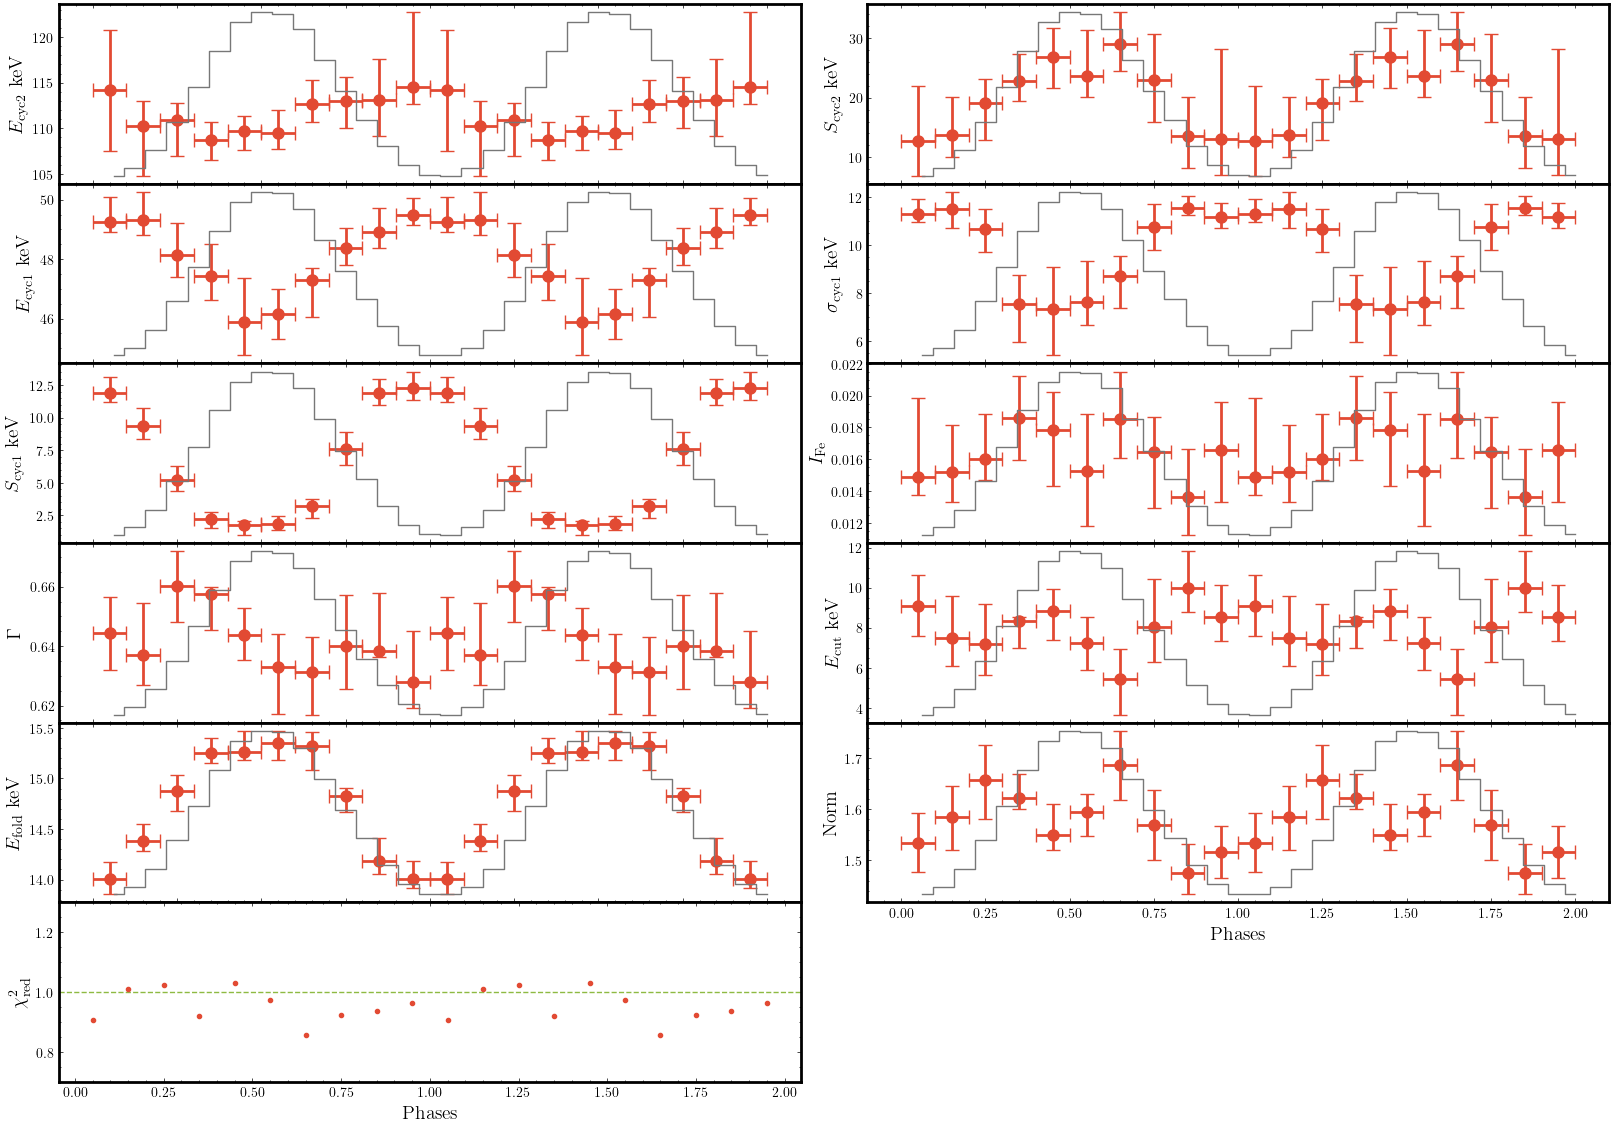

In [42]:
X = np.array([0.05,0.15,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95])
x_data=np.hstack([X,X+1])
X_err=np.array([0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05])
x_err=np.hstack([X_err,X_err])
fig, axs = plt.subplots((M)//2+1, 2, figsize=(20, 14))
axs = axs.flatten()
#fig, axs = plt.subplots(M+1,1,figsize=(4, 16))
Ylabels=names
Ylabels=[r'$E_{\rm cyc2}$ keV',r'$S_{\rm cyc2}$ keV', 
         r'$E_{\rm cyc1}$ keV', r'$\sigma_{\rm cyc1}$ keV', r'$S_{\rm cyc1}$ keV', 
         r'$I_{\rm Fe}$', 
         r'$\Gamma$', r'$E_{\rm cut}$ keV', r'$E_{\rm fold}$ keV', r'Norm']
i=0
while i < len(names):
    name=names[i]
    y1=Para_all['%s'%name].values
    #print(np.mean(y1))
    y1_err=[abs(Para_all['%s_Lerrs'%name].values),abs(Para_all['%s_Rerrs'%name].values)]
    y1=np.hstack([y1,y1])
    #y1=abs(y1)
    y1_err=np.hstack([y1_err,y1_err])
    y1_err=abs(y1_err)
    axs[0+i].errorbar(x_data, y1, xerr=x_err, yerr=y1_err, 
                      fmt='o', color=colors['red'], ecolor=colors['red'], capsize=5, markersize=8, elinewidth=2)
    axs2 = axs[0+i].twinx()
    axs2.errorbar(phase_bins, profile/np.mean(profile), 
                  drawstyle='steps-mid',color=colors['gray'],ecolor=colors['gray'])
    #axs2.errorbar(phase_bins2, profile2/np.mean(profile2), drawstyle='steps-mid',color='b',ecolor='b',alpha=0.5)
    axs2.set_yticks([])
    axs[0+i].set_ylabel(Ylabels[i],fontsize=14, fontweight='bold',fontname='Times New Roman')
    axs[i].spines['top'].set_linewidth(2)
    axs[i].spines['right'].set_linewidth(2)
    axs[i].spines['bottom'].set_linewidth(2)
    axs[i].spines['left'].set_linewidth(2)
    i+=1
#plot reduced chi^2 of fitting: 
axs[0+i].errorbar(x_data,np.hstack([red_chi2_all,red_chi2_all]),fmt='.',color=colors['red'],ecolor=colors['red'])
axs[0+i].axhline(y=1, color=colors['green'], linestyle='--',lw=1)
axs[0+i].set_ylim(0.7,1.3)
#axs[0+i].set_xlim(0.0,2.0)
#设置边框
axs[i].spines['top'].set_linewidth(2)
axs[i].spines['right'].set_linewidth(2)
axs[i].spines['bottom'].set_linewidth(2)
axs[i].spines['left'].set_linewidth(2)
# 移除最后一个子图
fig.delaxes(axs[-1])
axs[-3].set_xlabel('Phases',fontsize=14, fontweight='bold',fontname='Times New Roman')
axs[0+i].set_ylim(0.7,1.3)
axs[0+i].set_ylabel(r'$\chi^2_{\rm red}$',fontsize=14, fontweight='bold',fontname='Times New Roman')
axs[0+i].set_xlabel('Phases',fontsize=14, fontweight='bold',fontname='Times New Roman')
plt.subplots_adjust(wspace=0.09,hspace=0)
#plt.savefig('/Users/kldsky/Desktop/1A0535_results/fdcut/20201208_fdcut.pdf')

In [43]:
for i in names:
    rms=100*(max(abs(Para_all[i].values))-(min(abs(Para_all[i].values))))/(abs(max(Para_all[i].values))+min(abs(Para_all[i].values)))
    K=np.mean(Para_all[i].values)
    #print('rms:',rms)
    print('mean:',i,K)

mean: gabs2_Sigma 111.649
mean: gabs2_Strength 19.74349
mean: gabs1_LineE 48.025670000000005
mean: gabs1_Sigma 9.833248999999999
mean: gabs1_Strength 6.716125
mean: gaussian1_norm 0.0163032
mean: fdcut1_Gamma1 0.6413618999999999
mean: fdcut1_Ecut 8.0242
mean: fdcut1_Efold 14.743680000000001
mean: fdcut1_norm 1.578964


chi2 (constant model): 46.97
Degrees of freedom (constant model): 19
chi2 (sin model): 2.76
Degrees of freedom (sin model): 16
F value: 85.48
p value: 4.597944e-10
Sigma: 6.12
P-value: 4.597944e-10


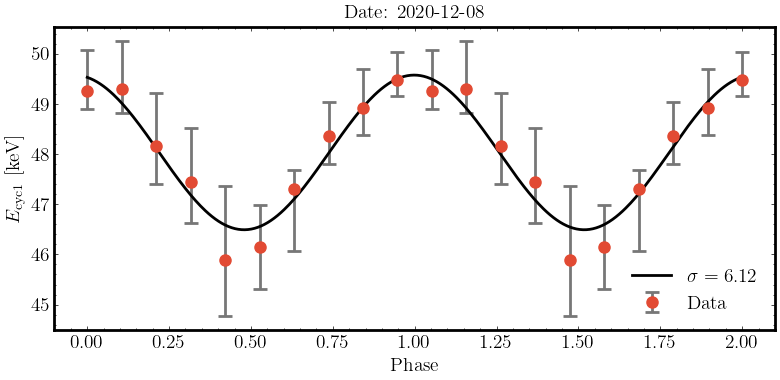

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import chi2
import scipy.stats as stats

# 定义常数函数和正弦函数
def const_func(x, C):
    return C

def sin_func(x, A, omega, phi, C):
    return A * np.cos(omega * x + phi) + C

# 数据
name0 = 'gabs1_LineE'
x = np.linspace(0, 2, 20)
# 这里需要使用实际数据集 Para_all，如果没有数据，可以用随机数据代替
y1 = Para_all['%s' % name0].values
y1_errL = abs(Para_all['%s_Lerrs' % name0].values)
y1_errR = abs(Para_all['%s_Rerrs' % name0].values)
# 示例数据
# y1 = np.random.rand(20)  # 请用实际数据替换
# y1_errL = np.random.rand(20) * 0.1  # 请用实际数据替换
# y1_errR = np.random.rand(20) * 0.1  # 请用实际数据替换

y1 = np.hstack([y1, y1])
y1_errL = np.hstack([y1_errL, y1_errL])
y1_errR = np.hstack([y1_errR, y1_errR])

y_edge1_MaxTau = y1
y_err_lower_edge1_MaxTau = y1_errL
y_err_upper_edge1_MaxTau = y1_errR
y_err_edge1_MaxTau = (y_err_lower_edge1_MaxTau + y_err_upper_edge1_MaxTau) / 2

# 常数函数拟合
params_const, _ = curve_fit(const_func, x, y_edge1_MaxTau, sigma=y_err_edge1_MaxTau, absolute_sigma=True)
y_fit_const = const_func(x, *params_const)
chi2_const = np.sum(((y_edge1_MaxTau - y_fit_const) / y_err_edge1_MaxTau) ** 2)
dof_const = len(y_edge1_MaxTau) - len(params_const)

# 正弦函数拟合
params_sin, params_covariance_sin = curve_fit(sin_func, x, y_edge1_MaxTau, sigma=y_err_edge1_MaxTau, absolute_sigma=True, 
                                              p0=[40, 2*np.pi, 0, 0.4])
y_fit_sin = sin_func(x, *params_sin)
chi2_sin = np.sum(((y_edge1_MaxTau - y_fit_sin) / y_err_edge1_MaxTau) ** 2)
dof_sin = len(y_edge1_MaxTau) - len(params_sin)

# 计算 F 值
F_value = ((chi2_const - chi2_sin) / (dof_const - dof_sin)) / (chi2_sin / dof_sin)

# 计算 p 值
p_value = 1 - stats.f.cdf(F_value, dof_const - dof_sin, dof_sin)

# 输出结果
print(f"chi2 (constant model): {chi2_const:.2f}")
print(f"Degrees of freedom (constant model): {dof_const}")
print(f"chi2 (sin model): {chi2_sin:.2f}")
print(f"Degrees of freedom (sin model): {dof_sin}")
print(f"F value: {F_value:.2f}")
print(f"p value: {p_value:.6e}")  # 使用科学计数法显示非常小的p值

# 计算 Z 分数（标准差数）
z_score = stats.norm.ppf(1 - p_value)  # 使用 1 - p_value 计算Z分数

# 使用更多的点使得拟合线条更平滑
x_smooth = np.linspace(0, 2, 400)
y_fit_smooth_sin = sin_func(x_smooth, *params_sin)

# 绘制拟合结果图像
fig, ax = plt.subplots(figsize=(8, 4))

# 绘制数据点和误差棒
ax.errorbar(x, y_edge1_MaxTau, yerr=[y_err_lower_edge1_MaxTau, y_err_upper_edge1_MaxTau], fmt='o', label='Data', color=colors['red'], ecolor=colors['gray'], elinewidth=2, capsize=5, capthick=2, markersize=8)

# 添加 sigma 值的文本
textstr = r'$\sigma=%.2f$' % z_score

# 绘制平滑后的拟合正弦波
ax.plot(x_smooth, y_fit_smooth_sin, label=textstr, color='black', linewidth=2)

# 设置文本框的外观
#props = dict(boxstyle='round', facecolor='white', alpha=0.5)
#ax.text(0.25, 0.95, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top')

# 设置标签和标题
ax.set_xlabel('Phase', fontsize=14, fontweight='bold',fontname='Times New Roman')
ax.set_ylabel(r'$E_{\rm cyc1}$ [keV]', fontsize=14, fontweight='bold',fontname='Times New Roman')
# 显示图例
ax.legend(loc='lower right', fontsize=14)

# 去掉网格
ax.grid(False)

# 调整刻度和刻度标签
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_title('Date: 2020-12-08', fontsize=14, fontweight='bold',fontname='Times New Roman')
# 美化图形外观
fig.tight_layout()
# 保存图像为PDF（如需要）
#fig.savefig("/Users/kldsky/Desktop/1A0535_results/fdcut/20201208_fdcut_sigma.pdf")
print(f"Sigma: {z_score:.2f}")
print(f"P-value: {p_value:.6e}")

In [45]:
print(np.mean(Para_all['%s' % name0].values)),print(np.max(Para_all['%s' % name0].values)),print(np.min(Para_all['%s' % name0].values))

48.025670000000005
49.4778
45.8961


(None, None, None)

In [46]:
print([np.array(Para_all['%s' % name0].values)])
print([Para_all['%s_Lerrs' % name0].values,Para_all['%s_Rerrs' % name0].values])

[array([49.2479, 49.3045, 48.1532, 47.439 , 45.8961, 46.1403, 47.3092,
       48.3685, 48.9202, 49.4778])]
[array([0.3489, 0.4962, 0.7493, 0.8177, 1.1308, 0.8375, 1.242 , 0.5579,
       0.5402, 0.3217]), array([0.8305, 0.9564, 1.0674, 1.0816, 1.4729, 0.8511, 0.3772, 0.6721,
       0.784 , 0.5636])]
